In [1]:
import sys
sys.path.append('..')
import numpy as np
import pickle 
import matplotlib.pyplot as plt
from utils import d_sl, years, compute_weights_lon, ssp, version, DATA_PATH
from sklearn.linear_model import LinearRegression
from produce_maps.tcrit import data_both_biomes
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

d_ext = {"South America": "south_america",  "Africa": "africa", "SE Asia": "south_east_asia"}
d_ext = {value: key for key, value in d_ext.items()}
d_ext_latex = { # for latex
    "South America": 'SA',
    "SE Asia": 'SEA',
    "Africa": "A"
}
plt.rcParams.update({'font.size': 20})


# Relies on outputs of biome_continent_per_year.py and slope.py

0.8 SE Asia 0.018465981849153934 4.349996337890623
0.9 SE Asia 0.014210463903900461 1.710012207031248
0.8 South America 0.0686280676246418 0.8800109863281236
0.9 South America 0.05721000223948547 -3.9599853515625014
0.8 Africa 0.04409854855377837 6.629987792968748
0.9 Africa 0.016001020893486206 3.3000109863281253


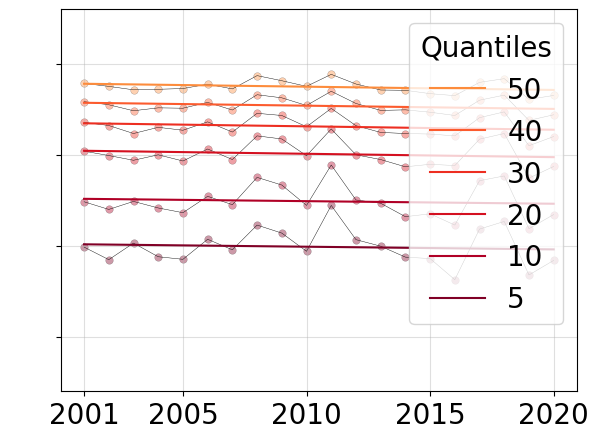

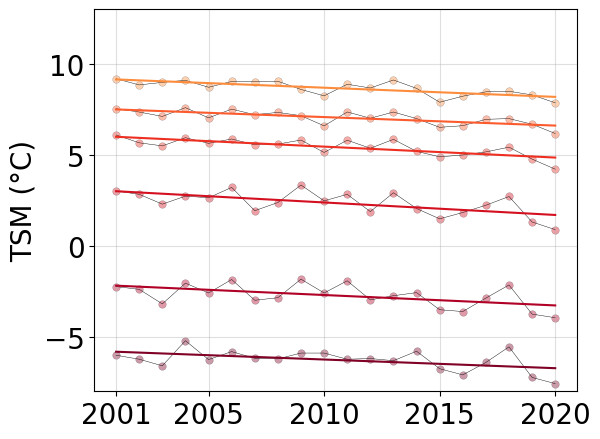

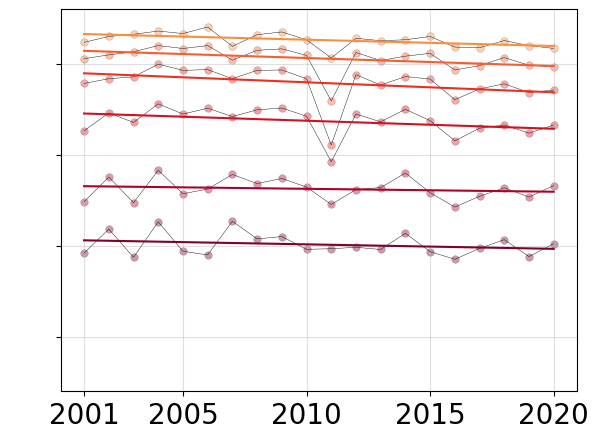

In [17]:
def f(sl, ext):
    outfile = DATA_PATH + f'/outputs/continents/quantilesTSM_{"_".join(years)}_{ext}_Tcrit_{ssp}{version}.pkl'
    with open(outfile, 'rb') as file:
        d_hansen_temp = pickle.load(file)
    return d_hansen_temp

points = np.linspace(0.5, 1.0, 6)
colormap = plt.get_cmap('YlOrRd')
colors = [colormap(point) for point in points]
quantiles = ['median', '0.6', '0.7', '0.8', '0.9', '0.95']


for key, sl in d_sl.items():
    ext = key
    key = d_ext[key]
    legend = key 
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    if key == "South America":
        ax.set_ylabel("TSM (°C)")
    linestyle = 'solid'
    d_hansen_temp = f(sl, ext)


    for color, quantile in zip(colors, quantiles):
        min_median = d_hansen_temp[quantile]
        min_median = -1 * np.asarray([min_median[i][0] for i in range(len(d_hansen_temp[quantile].keys()))])
        min_median = min_median#[:-2]

        model_min_median = LinearRegression()
        X = np.arange(len(years)).reshape(-1, 1)
        model_min_median.fit(X, min_median)
        y = model_min_median.predict(X)
        if quantile == '0.9' or quantile == '0.8':
            # pass
            print(quantile, key, y[0]-y[1], min_median[-1])
        coef = np.round(model_min_median.coef_[0], 4)
        x = np.arange(len(min_median))
        ax.plot(x, min_median, color='black', linewidth=0.3)
        ax.plot(years, y, color=color, linestyle=linestyle)
        plt.scatter(x, min_median, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)
        
        
        ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
        if quantile == 'median':
            quantile = '0.5'
        ax.plot([], c=color, label=str(int(100*np.round(1-float(quantile), 2))))
        plt.ylim(-8,13)
        
    plt.grid(alpha=0.4)
    if key != "South America":
        plt.gca().yaxis.set_tick_params(labelcolor='none')
    if key == "SE Asia":
        
        ax.legend(title="Quantiles", loc=1)
    plt.tight_layout() 
    plt.savefig(f"../figures/Figure2/TSM_LR/{d_ext_latex[key]}.png", bbox_inches='tight')
    

[13.67829179 14.02908567 15.25347168 13.77824809 14.14328697 13.07427731
 15.64171024 15.00139458 12.74470834 14.43635425 13.45280806 15.8341738
 14.24179303 15.3695494  16.86320856 16.1830076  15.00337432 13.93158957
 17.0450972  17.8607017 ]


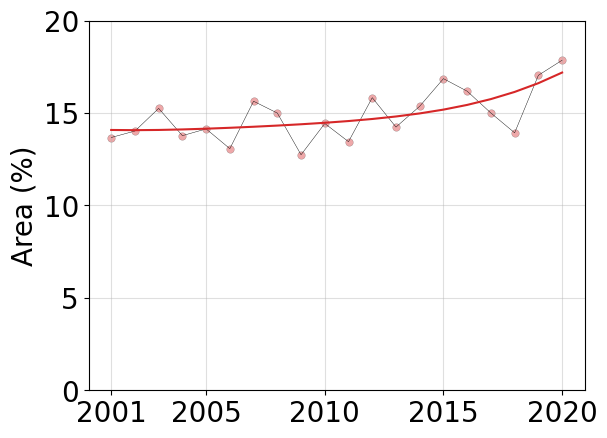

: 

In [ ]:
# Polynomial 
for key, sl in list(d_sl.items()):
    ext = key
    key = d_ext[key]
    if key != "South America":
        continue
    color = 'tab:red' 
    outfile = DATA_PATH + f"/outputs/delta_Tmin_Tmodis{ext}_per_year_2001_2020_reversed{version}.npy"
    map = np.load(outfile)
    map = map.astype(float)
    map[~data_both_biomes[sl]] = np.nan
    weights_lon = compute_weights_lon(sl)
    above_threshold_map =  ((map > 0).transpose((2,0,1)) * weights_lon).transpose((1,2,0))
    above_threshold_map = above_threshold_map.astype(float)
    above_threshold_map[np.isnan(map)] = np.nan
    above_thresholds = np.nansum(np.nansum(above_threshold_map, axis=0) , axis=0)
    y = above_thresholds/np.sum(~np.isnan(map[...,0]) * weights_lon)*100 

    model = LinearRegression()
    model = make_pipeline(PolynomialFeatures(4), Ridge(alpha=1e-5))
    X = np.arange(len(years)).reshape(-1, 1)
    model.fit(X, y)
    pred = model.predict(X)
    x = np.arange(len(y))
        
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    ax.set_ylabel("Area (%)")
    ax.plot(x, y, color='black', linewidth=0.3)
    ax.plot(years, pred, color=color, label=key)
    print(y)
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)


    ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
    plt.ylim(0,20)
    plt.grid(alpha=0.4)
    plt.savefig(f"../figures/Figure2/surface_over_threshold/{d_ext_latex[key]}.png", bbox_inches='tight')

[5.12071436 6.12152861 4.7897371  5.94224963 6.18167829 4.48424873
 5.35388349 3.64709925 4.13076524 5.46955278 2.39026441 4.482612
 5.03397639 6.16419345 6.1690831  7.85897641 3.87799997 3.40176247
 7.85326097 6.23328395]


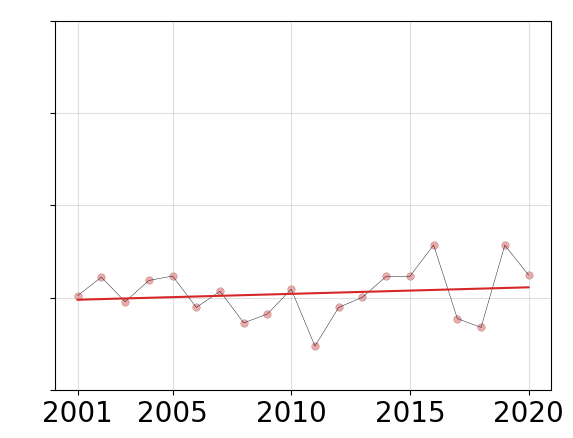

In [4]:
for key, sl in list(d_sl.items()):
    ext = key
    key = d_ext[key]
    if key != "SE Asia":
        continue
    color = 'tab:red'
    outfile = DATA_PATH + f"/outputs/delta_Tmin_Tmodis{ext}_per_year_2001_2020_reversed{version}.npy"
    map = np.load(outfile)
    map = map.astype(float)
    map[~data_both_biomes[sl]] = np.nan
    weights_lon = compute_weights_lon(sl)
    above_threshold_map =  ((map > 0).transpose((2,0,1)) * weights_lon).transpose((1,2,0))
    above_threshold_map = above_threshold_map.astype(float)
    above_threshold_map[np.isnan(map)] = np.nan
    above_thresholds = np.nansum(np.nansum(above_threshold_map, axis=0) , axis=0)
    y = above_thresholds/np.sum(~np.isnan(map[...,0]) * weights_lon)*100 #ICI weights_lon

    model = LinearRegression()
    X = np.arange(len(years)).reshape(-1, 1)
    model.fit(X, y)
    pred = model.predict(X)
    x = np.arange(len(y))
        
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    ax.plot(x, y, color='black', linewidth=0.3)
    ax.plot(years, pred, color=color, label=key)
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)


    ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
    plt.ylim(0,20)
    plt.grid(alpha=0.4)
    plt.gca().yaxis.set_tick_params(labelcolor='none')
    print(y)
    plt.gca().yaxis.set_tick_params(labelcolor='none')
    plt.savefig(f"../figures/Figure2/surface_over_threshold/{d_ext_latex[key]}.png", bbox_inches='tight')

[5.6013886  3.82960553 5.91166117 3.45105011 5.41272256 5.60087863
 3.48486048 4.5391816  4.44442476 5.23641127 5.23966356 5.1267036
 5.23126851 4.24680493 5.40273094 6.04629896 5.19952206 4.58276696
 5.72973412 4.87458593]


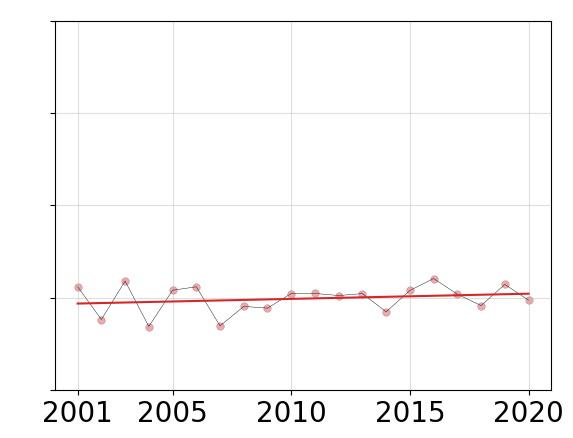

In [5]:


for key, sl in list(d_sl.items()):
    ext = key
    key = d_ext[key]
    if key != "Africa":
        continue
    color = 'tab:red'
    outfile = DATA_PATH + f"/outputs/delta_Tmin_Tmodis{ext}_per_year_2001_2020_reversed{version}.npy"
    map = np.load(outfile)
    map = map.astype(float)
    map[~data_both_biomes[sl]] = np.nan
    weights_lon = compute_weights_lon(sl)
    above_threshold_map =  ((map > 0).transpose((2,0,1)) * weights_lon).transpose((1,2,0))
    above_threshold_map = above_threshold_map.astype(float)
    above_threshold_map[np.isnan(map)] = np.nan
    above_thresholds = np.nansum(np.nansum(above_threshold_map, axis=0) , axis=0)
    y = above_thresholds/np.sum(~np.isnan(map[...,0]) * weights_lon)*100 #ICI weights_lon

    model = LinearRegression()
    X = np.arange(len(years)).reshape(-1, 1)
    model.fit(X, y)
    pred = model.predict(X)
    x = np.arange(len(y))
        
    fig = plt.figure()
    ax = fig.gca()
    ax.tick_params(axis='y')
    ax.plot(x, y, color='black', linewidth=0.3)
    ax.plot(years, pred, color=color, label=key)
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=.25, s=30, alpha=0.4)


    ax.set_xticks([0, 4, 9, 14, 19], [2001, 2005, 2010, 2015, 2020])
    plt.ylim(0,20)
    plt.grid(alpha=0.4)
    print(y)
    plt.gca().yaxis.set_tick_params(labelcolor='none')
    plt.savefig(f"../figures/Figure2/surface_over_threshold/{d_ext_latex[key]}.png", bbox_inches='tight')